<a href="https://colab.research.google.com/github/Marzkartella/Marzkartella/blob/main/Employee_Data_Untitled12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



In [19]:

# Load the dataset
file_path = "/content/employee_data.csv"
df = pd.read_csv(file_path)

# Display basic information about the dataset
df_info = df.info()
df_head = df.head()
df_description = df.describe(include='all')

df_info, df_head, df_description


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

(None,
    Age Attrition     BusinessTravel  DailyRate              Department  \
 0   41       Yes      Travel_Rarely       1102                   Sales   
 1   49        No  Travel_Frequently        279  Research & Development   
 2   37       Yes      Travel_Rarely       1373  Research & Development   
 3   33        No  Travel_Frequently       1392  Research & Development   
 4   27        No      Travel_Rarely        591  Research & Development   
 
    DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
 0                 1          2  Life Sciences              1               1   
 1                 8          1  Life Sciences              1               2   
 2                 2          2          Other              1               4   
 3                 3          4  Life Sciences              1               5   
 4                 2          1        Medical              1               7   
 
    ...  RelationshipSatisfaction StandardHours  Stoc

Dataset Overview
Rows: 1470

Columns: 35

First Few Rows:

Age	Attrition	BusinessTravel	...
0	41	Yes	Travel_Rarely	...
1	49	No	Travel_Frequently	...
Includes both numeric and categorical data



In [20]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Replace missing numerical values with median
for col in numerical_cols:
    if col in df.columns and df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

# Replace missing categorical values with mode
for col in categorical_cols:
    if col in df.columns and df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)

# Recheck for missing values
remaining_missing = df.isnull().sum().sum()

missing_values, remaining_missing


(Series([], dtype: int64), np.int64(0))

**Missing Values Analysis**

No missing values were originally found in the dataset.

After checking and attempting replacements, there are 0 missing values.

In [21]:
# Compute skewness for numerical columns
skewness = df[numerical_cols].skew().sort_values(ascending=False)
skewness


,0
YearsSinceLastPromotion,1.984290
PerformanceRating,1.921883
YearsAtCompany,1.764529
MonthlyIncome,1.369817
TotalWorkingYears,1.117172
NumCompaniesWorked,1.026471
JobLevel,1.025401
StockOptionLevel,0.968980
DistanceFromHome,0.958118
YearsInCurrentRole,0.917363


**Skewness Analysis**

Skewness measures how asymmetrical the data distribution is:

Positive skew: Tail on the right

Negative skew: Tail on the left

Here are some notable values:

**Highly Skewed:**

YearsSinceLastPromotion (1.98)

PerformanceRating (1.92)

YearsAtCompany (1.76)

MonthlyIncome (1.37)

Near-Symmetric or Normal:

MonthlyRate, EmployeeNumber, StandardHours, DailyRate

These skewed variables may benefit from transformation (e.g., log-scaling) for modeling.

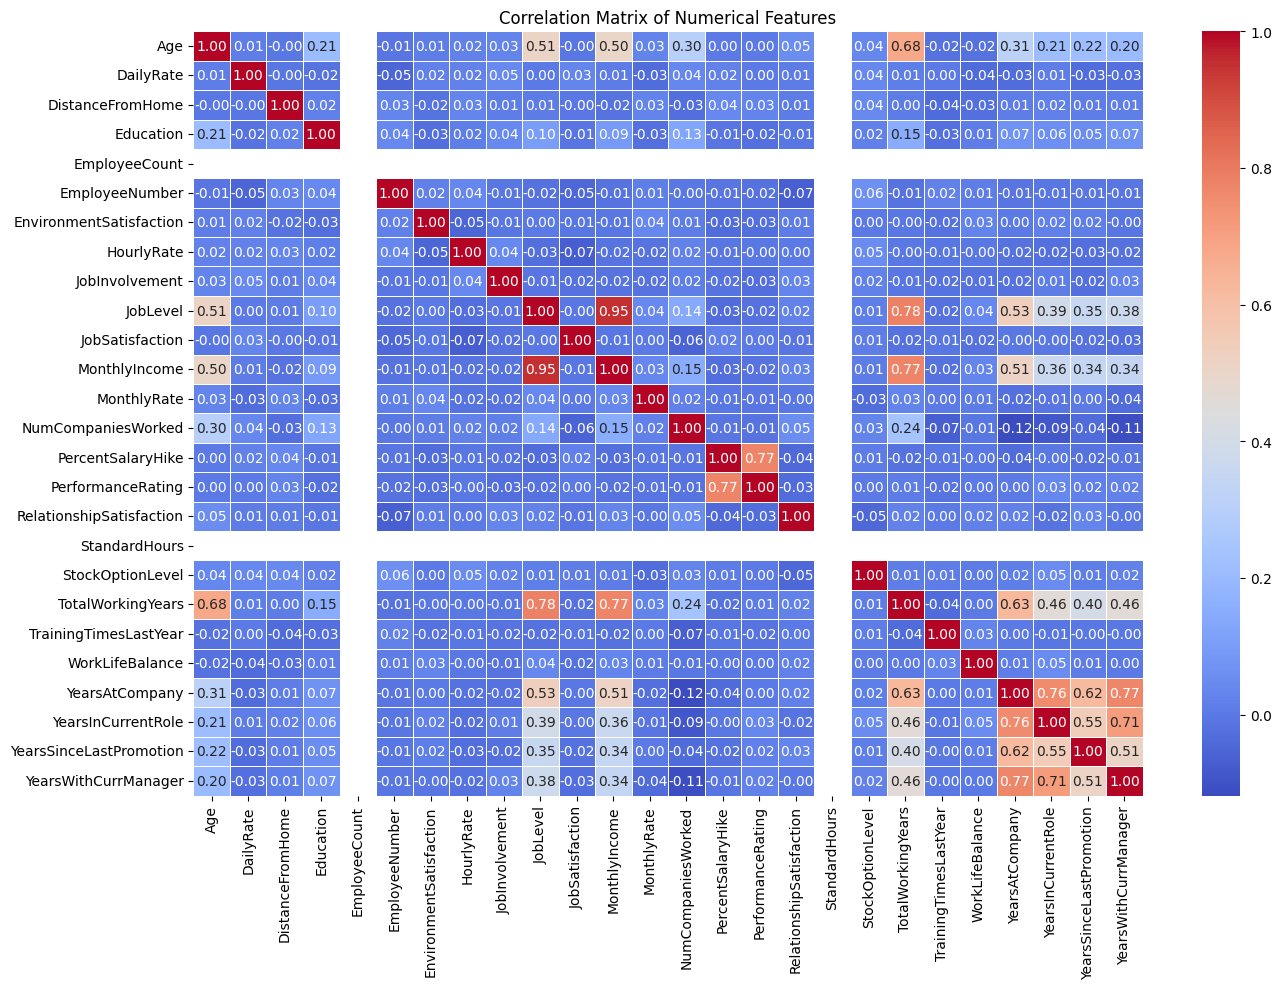

In [22]:
# Compute correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()


**Correlation Matrix Insights**

Here are some key observations from the heatmap:

*   **Strong Correlations:**
 1.   TotalWorkingYears and YearsAtCompany: 0.77
 2.   MonthlyIncome and JobLevel: 0.95
 3.   YearsInCurrentRole and YearsWithCurrManager: 0.77

*    **Low/No Correlation:**
 1.   PerformanceRating, EnvironmentSatisfaction, and DailyRate show weak correlations with most other variables.

Strongly correlated variables might be redundant in some models (e.g., linear models) and may require dimensionality reduction.

In [23]:
# Calculate probabilities (relative frequencies) for selected categorical variables
prob_attrition = df['Attrition'].value_counts(normalize=True)
prob_jobrole = df['JobRole'].value_counts(normalize=True)
prob_educationfield = df['EducationField'].value_counts(normalize=True)

prob_attrition, prob_jobrole.head(), prob_educationfield.head()


(Attrition
 No     0.838776
 Yes    0.161224
 Name: proportion, dtype: float64,
 JobRole
 Sales Executive              0.221769
 Research Scientist           0.198639
 Laboratory Technician        0.176190
 Manufacturing Director       0.098639
 Healthcare Representative    0.089116
 Name: proportion, dtype: float64,
 EducationField
 Life Sciences       0.412245
 Medical             0.315646
 Marketing           0.108163
 Technical Degree    0.089796
 Other               0.055782
 Name: proportion, dtype: float64)

**Probability Distributions (Relative Frequencies)**

* **Attrition:**
  * No: 83.88%
  * Yes: 16.12%

* **Top 5 Job Roles:**
  * Sales Executive: 22.18%
  * Research Scientist: 19.86%
  * Laboratory Technician: 17.62%
  * Manufacturing Director: 9.86%
  * Healthcare Representative: 8.91%

* **Top 5 Education Fields:**
  * Life Sciences: 41.22%
  * Medical: 31.56%
  * Marketing: 10.82%
  * Technical Degree: 8.98%
  * Other: 5.58%

This gives a good sense of the employee background and attrition behavior.

In [24]:
# Encode categorical features
df_encoded = df.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Define features and target
X = df_encoded.drop('Attrition', axis=1)
y = df_encoded['Attrition']  # Already encoded (0 for No, 1 for Yes)

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled[:5], y_train[:5].values


(array([[-1.38855944,  0.58928051, -1.10813858, -0.50017392,  1.44039645,
         -0.86335572,  2.08560653,  0.        ,  0.86066608,  0.2797056 ,
          0.81447304, -0.47283217, -1.01234042, -0.9322736 , -1.00880128,
         -1.58233648, -1.48641297, -0.86827746, -0.60189535, -1.05916816,
          0.        , -0.63641018, -0.33924934, -0.42929015, -0.63982217,
          0.        ,  2.54747106, -1.1673683 ,  0.15731946,  0.3574354 ,
         -0.97426331, -0.88820751, -0.67610953, -1.14244794],
        [-2.04073779, -2.46355596, -1.2634814 , -0.50017392, -0.52269928,
         -0.86335572, -0.93028437,  0.        , -0.02681063, -0.63910385,
          0.81447304,  0.30937375,  0.38991203, -0.9322736 ,  0.609133  ,
          1.15283407,  1.27071897, -1.13280679, -0.11531844, -0.65943075,
          0.        , -0.63641018, -0.06636478, -0.42929015,  1.21117628,
          0.        , -0.94552463, -1.42339685, -0.61354589,  0.3574354 ,
         -1.13857331, -1.1650514 , -0.67610953, -1

**Preprocessing Done:**

Encoded all categorical features.

Scaled numerical data.

Split into training (80%) and test (20%) sets.

In [25]:
# Initialize and train KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Predict on test data
y_pred = knn.predict(X_test_scaled)

# Evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

conf_matrix, class_report, accuracy


(array([[252,   3],
        [ 34,   5]]),
 '              precision    recall  f1-score   support\n\n           0       0.88      0.99      0.93       255\n           1       0.62      0.13      0.21        39\n\n    accuracy                           0.87       294\n   macro avg       0.75      0.56      0.57       294\nweighted avg       0.85      0.87      0.84       294\n',
 0.8741496598639455)